# ANN

The aim of this project is to implement a basic neural network from scratch.

Let's set up the project and look at our data.

## Setup

In [1]:
using Images
using Compose
using Distributions
using Gadfly

In [2]:
include("ann.jl");

In [3]:
df = dataset();

In [4]:
samples = sample(df[df[:y] .== 8, :image], 200);

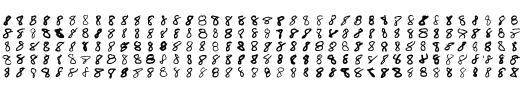

In [5]:
pngs = [to_png(256 - img) for img in samples]
draw(grid(pngs; n_cols = 40)...)

## LinearTransform

Let's try to predict instance. This model simply averages the images in the trainset, grouped by class label.

In [6]:
folds = cv(RandomKFolds, df)
Yp, models = cvpredict(LinearTransform, folds, NoopOpt(), df);

### Evaluation

Let's look at the one vs all evaluation on this training set prediction run:

In [7]:
evaluation(Yp)

,class,accuracy,precision,recall
1,0,0.945,0.654,0.947
2,1,0.885,0.494,0.993
3,2,0.957,0.914,0.633
4,3,0.947,0.748,0.718
5,4,0.965,0.846,0.779
6,5,0.945,0.904,0.441
7,6,0.967,0.878,0.773
8,7,0.964,0.891,0.747
9,8,0.944,0.832,0.537
10,9,0.947,0.75,0.705


In [8]:
describe(evaluation(Yp)[[:precision, :recall]])

precision
Min      0.494
1st Qu.  0.7484999999999999
Median   0.839
Mean     0.7911
3rd Qu.  0.88775
Max      0.914
NAs      0
NA%      0.0%

recall
Min      0.441
1st Qu.  0.651
Median   0.7324999999999999
Mean     0.7273
3rd Qu.  0.7775000000000001
Max      0.993
NAs      0
NA%      0.0%



### Confusion matrix

The most confused digits:

In [9]:
confusions(Yp)[1:10, :]

,y,prediction,x1
1,8,1,1623
2,5,1,1175
3,2,1,1003
4,7,1,995
5,3,1,981
6,5,3,932
7,9,1,793
8,2,0,708
9,4,1,700
10,6,0,696


Overall confusion matrix:

In [10]:
confusion_matrix(Yp; n_classes = 10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
1,6539,49,10,39,6,19,155,4,62,20
2,0,7821,13,9,2,2,9,5,13,3
3,708,1003,4422,173,117,1,251,97,195,23
4,334,981,140,5128,11,20,57,114,214,142
5,207,700,19,0,5318,19,79,16,30,436
6,690,1175,52,932,110,2785,148,57,114,250
7,696,694,54,3,25,70,5313,1,20,0
8,159,995,24,22,99,2,2,5448,34,508
9,399,1623,94,463,74,161,38,53,3666,254
10,268,793,11,85,521,3,1,317,57,4902


### Confusing instances

The following numbers were misclassified:

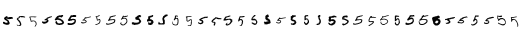

In [11]:
specimen = 5
filtered = Yp[(Yp[:y] .== specimen) & (Yp[:prediction] .!= specimen), :]
draw(grid([to_png(256 - img) for img in sample(filtered[:image], 40)]; n_cols = 40)...)

Let's have a look at the distribution over those misclassifications:

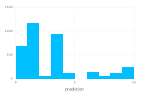

In [12]:
plot(filtered, x = :prediction, Geom.histogram)

The most common confusion is 8, then 3. This is not super surprising; we can see how those might look similar.

### Understanding the model

Let's have a look at the weights of the model. We should be able to visualize the averaged number present in each column. Showing the model learned in the first few folds here:

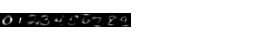

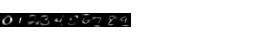

In [13]:
for model in models[1:2]
    masks = model.weights * 2^18.4 # scale up until we see something
    pngs = [to_png(bound(masks[:, i])) for i in 1:10]
    draw(grid(pngs; n_cols = 20)...)
end

So in fact all we're doing is projecting new images against the prototype images we've calculated. Since both vectors have been l2 normalized to unit length, this is equivalent to the cosine distance between those vectors. We pick the one with the smallest angle (eg. the largest projection). 

Another way to view this is that we've stored image masks. Since most of the values in the weights are 0 (black), those pixels will be ignored in the source image, while the white areas will have a value if the input image has ink there. 

## Binary Logistic Regression

This time, let's learn a binary logistic regression model using gradient descent. This model is fully derived using MLE in [the scratch notebook](http://nbviewer.jupyter.org/github/purzelrakete/hi/blob/master/ann/scratch.ipynb#Binary-Logistic-Regression).

In [14]:
folds = cv(RandomKFolds, sample_df(df, 100), 3)
Yp, models = cvpredict(BinaryLogReg, folds, BatchGradientDescent(0.03, 1), df);

### Evaluation

There's some work left to do to get binary logistic regression working in this multiclass setting, as we can see below.

In [15]:
evaluation(Yp)

,class,accuracy,precision,recall
1,0,0.73,0.306,0.846
2,1,0.79,0.0,0.0
3,2,0.9,0.0,0.0
4,3,0.83,0.2,0.182
5,4,0.85,0.3,0.273
6,5,0.8,0.0,0.0
7,6,0.84,0.0,0.0
8,7,0.87,0.0,0.0
9,8,0.85,0.0,0.0
10,9,0.86,0.0,0.0
